In [62]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [63]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
train_x = torch.tensor([0.])
train_y = torch.tensor([0.])
likelihood = gpytorch.likelihoods.GaussianLikelihood()
likelihood.noise = 1e-4
model = ExactGPModel(train_x, train_y, likelihood)

In [64]:
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(-20, 20, 400)
    observed_pred = likelihood(model(test_x))

Alpha = torch.distributions.Normal(loc=torch.tensor([0.]), scale=torch.tensor([1.]))
Beta = torch.distributions.chi2.Chi2(torch.tensor([.1]))
X_star = torch.distributions.Normal(loc=torch.tensor([0.]), scale=torch.tensor([1.]))

In [71]:
def sample_prior():
    test_x_star = torch.linspace(-10, 10, 200)
    alpha = Alpha.sample()
    beta = Beta.sample()
    x_star = X_star.sample()
    obs = observed_pred.sample()

    i_star = int(10*(10 - x_star))
    g_eval = alpha + beta*torch.abs(test_x_star - x_star) + (obs[i_star:(i_star + 200)])**2
    return g_eval

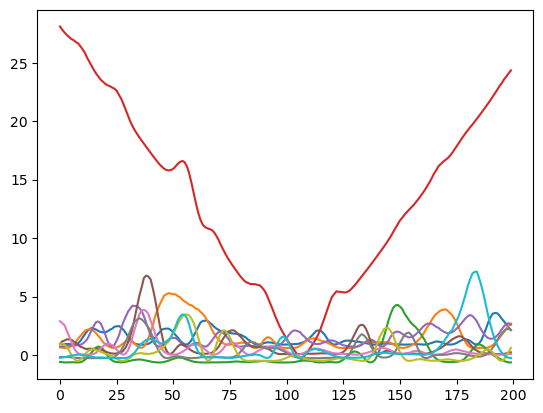

In [74]:
## Sample prior parameters

for _ in range(10):
    plt.plot(sample_prior())